In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pandas as pd

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/texturemodel/code/'
sys.path.insert(0,codepath)

import copy

from plotting import plot_utils, summary_plots, load_fits
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils, prf_utils, numpy_utils

/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load model fits

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False) \
                                   for ss in subjects]
# shuffled model fits, to compute significance of model fit each ROI.
fitting_type_shuffle = 'texture_pyramid_ridge_4ori_4sf_pcaHL_use_texture_pRFs_permutation_test'
out_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type_shuffle, \
                                  n_from_end=0, verbose=False) \
                                    for ss in subjects]

#### Pull out the pRF params

In [3]:
prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = sigma * screen_eccen_deg

In [4]:
unique_size = np.unique(size_fwrf.round(3))
unique_eccen = np.unique(eccen_fwrf.round(3))
unique_size, unique_eccen
n_size = len(unique_size)
n_eccen = len(unique_eccen)

#### Make ROI definitions

In [5]:
roi_def = roi_utils.multi_subject_roi_def(subjects, areas_include = ['V1','V2','V3','hV4', \
                                                      'OPA','PPA','RSC',\
                                                      'FFA','EBA'], use_kastner_areas=False, \
                                         remove_ret_overlap=True, remove_categ_overlap=True)
roi_names = roi_def.roi_names;
n_rois = len(roi_names)

#### Process results of permutation test, compute p-values

In [6]:
pvals_singlevoxels_modelsig = [[] for si in range(n_subjects)]

for si in range(n_subjects):

    # stats for single voxels
    r2_real = out[si]['val_r2']
    r2_shuff = out_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p = np.mean(r2_real[:,0,None]<=r2_shuff[:,0,:], axis=1)
    _,pvals_fdr = stats_utils.fdr_keepshape(p, alpha=0.01, \
                                                   method='poscorr')
    
    pvals_singlevoxels_modelsig[si] = pvals_fdr
    

In [7]:
r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
r2.shape

(150842,)

#### Threshold the voxels based on noise ceiling and result of permutation test
Going to plot pRF params only for the vox passing these thresholds

In [8]:
noise_ceiling = np.concatenate([summary_plots.get_noise_ceiling(out[si]) \
                            for si in range(n_subjects)], axis=0)
abv_thresh = noise_ceiling>0.01
pvals = np.concatenate(pvals_singlevoxels_modelsig, axis=0)

abv_thresh = abv_thresh & (pvals<0.01)

#### Make violin plots for pRF size

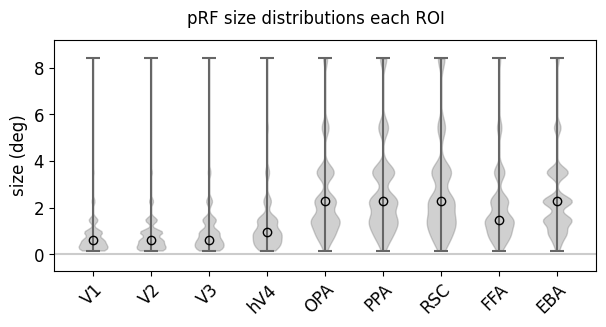

In [9]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

parslist = [size_fwrf]
parnames = ['size']
axnames = ['size (deg)']

ylims = [-0.7, 9.2]

color = [0.4, 0.4, 0.4]

for pp, pars in enumerate(parslist):
   
    pi=0
    # plt.figure(figsize=(12,3))
    plt.figure(figsize=(7,3))

    for rr in range(n_rois):

        inds_this_roi = roi_def.get_indices(rr) & abv_thresh
        vals = copy.deepcopy(pars[inds_this_roi])
         
        parts = plt.violinplot(vals,[rr])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        
        plt.plot(rr, np.median(vals), 'o',\
                     markeredgecolor='k',markerfacecolor='none')


    plt.ylabel(axnames[pp])
    plt.ylim(ylims)
    plt.axhline(0,color=[0.8, 0.8, 0.8], zorder=-20)  
    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')
           
    plt.suptitle('pRF %s distributions each ROI'%parnames[pp])

    fn2save = os.path.join(default_paths.fig_path, 'texture_prf_%s_violins.pdf'%parnames[pp])
    plt.savefig(fn2save)

#### Plot size/eccentricity relationship (line with errorbars)

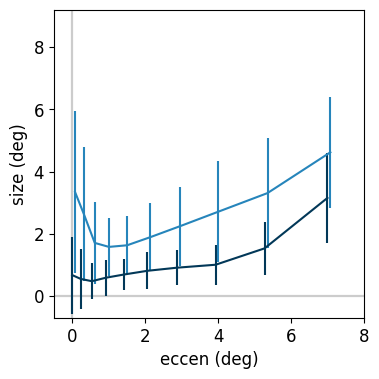

In [10]:
plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(12)
size_lims = [-0.7, 9.2]
eccen_lims = [-0.5, 7.5]
size_ticks = np.arange(0,9,2)
eccen_ticks = np.arange(0,9,2)

plt.figure(figsize=(4,4))

# to keep this plot simple, going to pool voxels into two rough groupings
# early and higher visual areas
roi_groups = [[0,1,2,3],[4,5,6,7,8]]

roi_group_colors = np.flipud(cm.PuBu(np.linspace(0,1,4))[2:])
linestyles = np.tile(['-','--',':'], int(n_rois/3))
lh = []

sp = 0.08

for rg in np.arange(2):

    roi_group_inds = np.any(np.array([roi_def.get_indices(rr) for rr in roi_groups[rg]]), axis=0)
    
    inds2use = roi_group_inds & abv_thresh
  
    xvals = eccen_fwrf[inds2use].round(3)
    yvals = size_fwrf[inds2use].round(3)
    
    xbinned, ybinned, ybin_std = numpy_utils.bin_ydata_by_xdata(xvals, yvals, \
                                                                n_bins=10,\
                                                                linear_bins=False,
                                                                use_unique=True,
                                                                return_std=True)
    
    plt.errorbar(xbinned+sp*rg, ybinned, ybin_std, color=roi_group_colors[rg,:])
    
    plt.xlim(eccen_lims)
    plt.ylim(size_lims)
    plt.yticks(size_ticks)
    plt.ylabel('size (deg)')
    
    plt.xticks(eccen_ticks)
    plt.xlabel('eccen (deg)')
         
    plt.axhline(0,color=[0.8, 0.8, 0.8], zorder=-20)
    plt.axvline(0,color=[0.8, 0.8, 0.8], zorder=-20)
    
fn2save = os.path.join(default_paths.fig_path,'Size_eccen_errbars_simple.pdf')
plt.savefig(fn2save)
